# ODV Plots

In [28]:
import xarray as xr
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

files = glob('E:/BeringSeaMoorings/data/physical/M8_historic/*.csv') # There are 4 files
das = []
for file in files:
    a = pd.read_csv(file,skiprows=[1]) # read it in
    a = a[['latitude','pressure','S_41','T_28']] # drop extra stuff, using lat as my 'distance'
    das.append(a.set_index(list(a.columns[0:2])).to_xarray())
dfAll = xr.merge(das)
dfAll # take a look

<xarray.Dataset>
Dimensions:   (latitude: 4, pressure: 118)
Coordinates:
  * latitude  (latitude) float64 61.36 61.85 62.19 62.2
  * pressure  (pressure) float64 0.0 1.0 2.0 3.0 4.0 ... 114.0 115.0 116.0 117.0
Data variables:
    S_41      (latitude, pressure) float64 nan nan nan nan ... nan nan nan nan
    T_28      (latitude, pressure) float64 nan nan nan nan ... nan nan nan nan

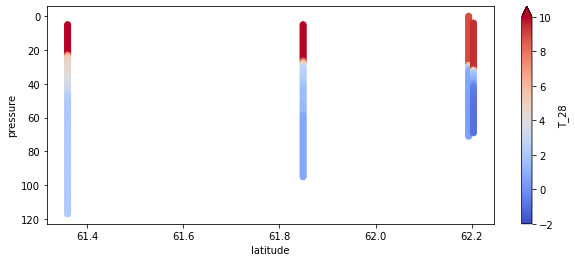

In [29]:
# Here are the actual casts, fo now I only care about T
fig = plt.figure(figsize=(10,4))
dfAll.plot.scatter(x='latitude',y='pressure',hue='T_28',vmin=-2,vmax=10,cmap='coolwarm')
plt.gca().invert_yaxis()

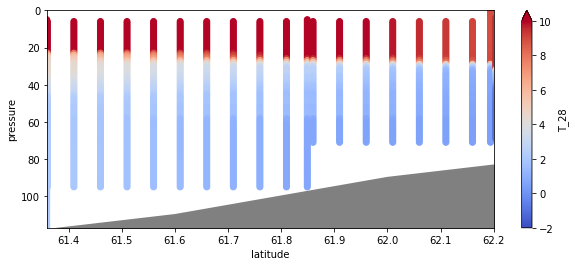

In [3]:
res_x = 0.05 # degrees latitude resolution
res_y = 1 # pressure bin size
dfInt = dfAll.interp(latitude=np.arange(np.round(dfAll.latitude.min().values,2),np.round(dfAll.latitude.max().values,2),res_x),
                     pressure=np.arange(np.round(dfAll.pressure.min().values,2),np.round(dfAll.pressure.max().values,2),res_y),method="linear",kwargs={"fill_value": "extrapolate"})
df = dfInt.merge(dfAll)

fig = plt.figure(figsize=(10,4))
df.plot.scatter(x='latitude',y='pressure',hue='T_28',vmin=-2,vmax=10,cmap='coolwarm')
x = [61.3,61.6,61.8,62.0,62.3]
y = [120,110,100,90,80]
plt.plot(x,y,color='grey')
plt.fill_between(x, y, 140,color='grey')
plt.xlim(np.round(dfAll.latitude.min().values,2),np.round(dfAll.latitude.max().values,2))
plt.ylim(np.round(dfAll.pressure.min().values,2),np.round(dfAll.pressure.max().values,2))
plt.gca().invert_yaxis()

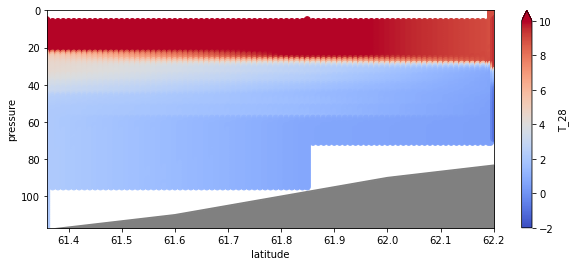

In [4]:
# We can increase the resolution to approximate a contour plot
res_x = 0.01 # degrees latitude resolution
res_y = 1 # pressure bin size
dfInt = dfAll.interp(latitude=np.arange(np.round(dfAll.latitude.min().values,2),np.round(dfAll.latitude.max().values,2),res_x),
                     pressure=np.arange(np.round(dfAll.pressure.min().values,2),np.round(dfAll.pressure.max().values,2),res_y),method="linear",kwargs={"fill_value": "extrapolate"})
df = dfInt.merge(dfAll)

fig = plt.figure(figsize=(10,4))
df.plot.scatter(x='latitude',y='pressure',hue='T_28',vmin=-2,vmax=10,cmap='coolwarm')
x = [61.3,61.6,61.8,62.0,62.3]
y = [120,110,100,90,80]
plt.plot(x,y,color='grey')
plt.fill_between(x, y, 140,color='grey')
plt.xlim(np.round(dfAll.latitude.min().values,2),np.round(dfAll.latitude.max().values,2))
plt.ylim(np.round(dfAll.pressure.min().values,2),np.round(dfAll.pressure.max().values,2))
plt.gca().invert_yaxis()

In [34]:
# One option is to take the interpolated data and grid, but that's essentially interpolating twice, so how about we just start with a grid there
# This is actually easier to do from a dataframe, so lets reorganize
dfAll = dfAll.to_dataframe().reset_index().dropna() 

In [40]:
res_x = 0.01
res_y = 1
# make lat/pres meshgrid
grid_x, grid_y = np.mgrid[np.round(dfAll.latitude.min(),2):np.round(dfAll.latitude.max(),2):res_x, np.round(dfAll.pressure.min(),2):np.round(dfAll.pressure.max(),2):res_y]

# interpolate into the grid from the original 4 casts
from scipy.interpolate import griddata
grid_z0 = griddata((dfAll.latitude,dfAll.pressure), dfAll.T_28, (grid_x, grid_y), method='linear',fill_value = np.nan)

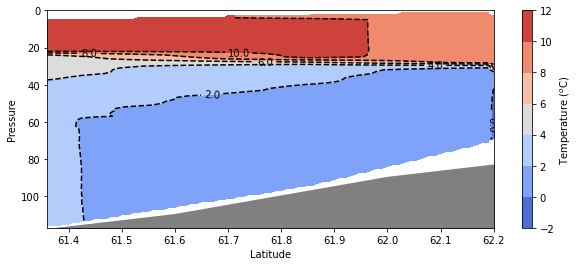

In [36]:
# we can plot it as a contour
fig = plt.figure(figsize=(10,4))
cm = plt.get_cmap('coolwarm')

cf = plt.contourf(grid_x,grid_y,grid_z0,[-2,0,2,4,6,8,10,12],cmap=cm,vmin=-2,vmax=12)
cl = plt.contour(grid_x,grid_y,grid_z0,[-2,0,2,4,6,8,10,12],colors='k',linestyles='--')
cl.clabel(fmt='%2.1f')
plt.xlabel('Latitude')
plt.ylabel('Pressure')
x = [61.3,61.6,61.8,62.0,62.3] #make a fake bottom
y = [120,110,100,90,80]  #make a fake bottom
plt.plot(x,y,color='grey') #make a fake bottom
plt.fill_between(x, y, 140,color='grey') #make a fake bottom
plt.xlim(np.round(dfAll.latitude.min(),2),np.round(dfAll.latitude.max(),2))
plt.ylim(np.round(dfAll.pressure.min(),2),np.round(dfAll.pressure.max(),2))
plt.gca().invert_yaxis()
plt.colorbar(cf,label='Temperature ($^o}$C)')

<ipython-input-41-661fa2008fb5>:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
  cm.set_under('lightgrey')
<ipython-input-41-661fa2008fb5>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = plt.pcolormesh(grid_x,grid_y,grid_z0,cmap=cm,vmin=-2,vmax=10)


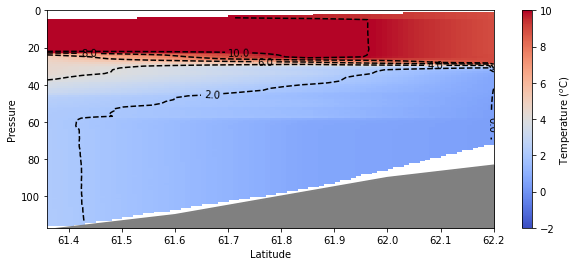

In [41]:
# or we can plot it as a pcolormesh, still with contour lines

fig = plt.figure(figsize=(10,4))
cm = plt.get_cmap('coolwarm')
cm.set_under('lightgrey')

c = plt.pcolormesh(grid_x,grid_y,grid_z0,cmap=cm,vmin=-2,vmax=10)
cl = plt.contour(grid_x,grid_y,grid_z0,[-2,0,2,4,6,8,10,12],colors='k',linestyles='--')
cl.clabel(fmt='%2.1f')

plt.xlabel('Latitude')
plt.ylabel('Pressure')
x = [61.3,61.6,61.8,62.0,62.3] #make a fake bottom
y = [120,110,100,90,80] #make a fake bottom
plt.plot(x,y,color='grey') #make a fake bottom
plt.fill_between(x, y, 140,color='grey') #make a fake bottom
plt.xlim(np.round(dfAll.latitude.min(),2),np.round(dfAll.latitude.max(),2))
plt.ylim(np.round(dfAll.pressure.min(),2),np.round(dfAll.pressure.max(),2))
plt.gca().invert_yaxis()
plt.colorbar(c,label='Temperature ($^o}$C)')

<ipython-input-38-3c4279f61eb1>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = plt.pcolormesh(grid_x,grid_y,grid_z0,cmap=cm,vmin=1440,vmax=1500)


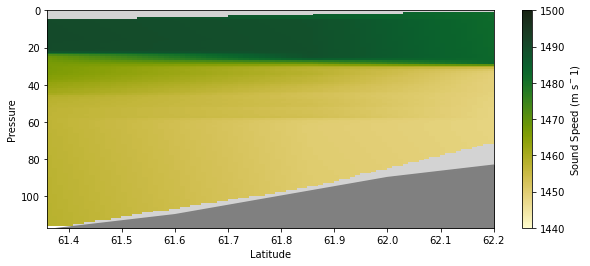

In [38]:
import seawater
import cmocean

dfAll['c'] = seawater.eos80.svel(dfAll.S_41, dfAll.T_28, dfAll.pressure) #get sound speed

res_x = 0.01
res_y = 1
# make lat/pres meshgrid
grid_x, grid_y = np.mgrid[np.round(dfAll.latitude.min(),2):np.round(dfAll.latitude.max(),2):res_x, np.round(dfAll.pressure.min(),2):np.round(dfAll.pressure.max(),2):res_y]

# interpolate into the grid from the original 4 casts
from scipy.interpolate import griddata
grid_z0 = griddata((dfAll.latitude,dfAll.pressure), dfAll.c, (grid_x, grid_y), method='linear',fill_value = -999) # I can fill the emptys so they come out light grey

fig = plt.figure(figsize=(10,4))
cm = cmocean.cm.speed
cm.set_under('lightgrey')

c = plt.pcolormesh(grid_x,grid_y,grid_z0,cmap=cm,vmin=1440,vmax=1500)

plt.xlabel('Latitude')
plt.ylabel('Pressure')
x = [61.3,61.6,61.8,62.0,62.3] #make a fake bottom
y = [120,110,100,90,80] #make a fake bottom
plt.plot(x,y,color='grey') #make a fake bottom
plt.fill_between(x, y, 140,color='grey') #make a fake bottom
plt.xlim(np.round(dfAll.latitude.min(),2),np.round(dfAll.latitude.max(),2))
plt.ylim(np.round(dfAll.pressure.min(),2),np.round(dfAll.pressure.max(),2))
plt.gca().invert_yaxis()
plt.colorbar(c,label='Sound Speed (m s$^-1}$)')

In [26]:
lat = 61.7
print('Integrated sound speed at ',str(lat),'N: ',np.mean(grid_z0[(grid_x==lat)&(grid_z0!=-999)]))

Integrated sound speed at  61.7 N:  1462.9084098404887
